<h1 style='color: yellow'> Metric Generator </h1>

Generates all the ToE metrics

In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep, time
from glob import glob
from pathlib import Path
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
import dask
from scipy.stats import spearmanr
# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import my_stats
import diagnostic_tools
import paths

import toe_calc as toe_calc
import toe_data_analysis as toe_da
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import toe_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/135756428.gadi-pbs/matplotlib-pt3dry15 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
xr.set_options(display_expand_data=False)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [4]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [5]:
# client.close()

In [6]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=30, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/135756428.gadi-pbs/dask-scratch-space/scheduler-qhxzzjxi', purging
 - Found stale lock file and directory '/jobfs/135756428.gadi-pbs/dask-scratch-space/worker-en1827rw', purging
 - Found stale lock file and directory '/jobfs/135756428.gadi-pbs/dask-scratch-space/worker-mimmrsz2', purging
 - Found stale lock file and directory '/jobfs/135756428.gadi-pbs/dask-scratch-space/worker-9wf82aai', purging
 - Found stale lock file and directory '/jobfs/135756428.gadi-pbs/dask-scratch-space/worker-2tkmshdk', purging
 - Found stale lock file and directory '/jobfs/135756428.gadi-pbs/dask-scratch-space/worker-_9wama3j', purging
 - Found stale lock file and directory '/jobfs/135756428.gadi-pbs/dask-scratch-space/worker-_cf015d4', purging
 - Found stale lock file and directory '/jobfs/135756428.gadi-pbs/dask-scratch-space/worker-rn5k8d18', purging
 - Found stale lock file and directory '/jobfs/135756428.gadi-pbs/dask-scratch-space/worker-v2

<Client: 'tcp://127.0.0.1:38429' processes=30 threads=30>

 - Register worker <WorkerState 'tcp://127.0.0.1:34253', name: 31, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:34253
 - Starting established connection to tcp://127.0.0.1:36380
 - Register worker <WorkerState 'tcp://127.0.0.1:33395', name: 39, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:33395
 - Starting established connection to tcp://127.0.0.1:36448
 - Register worker <WorkerState 'tcp://127.0.0.1:33491', name: 33, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:33491
 - Starting established connection to tcp://127.0.0.1:36396
 - Register worker <WorkerState 'tcp://127.0.0.1:40277', name: 37, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:40277
 - Starting established connection to tcp://127.0.0.1:36416
 - Register worker <WorkerState 'tcp://127.0.0.1:40151', name: 35, status: init, memory: 0, processing: 

In [7]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

In [8]:
np.sort(os.listdir(constants.TOE_SAVE_DIR))

array(['.ipynb_checkpoints', 'best_tas_(1880_1910)',
       'best_tas_(1890_1920)', 'best_tas_(1900_1930)',
       'best_tas_(1910_1940)', 'best_tas_(1920_1950)', 'era5', 'old',
       'to_delete'], dtype='<U20')

In [9]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.BasePeriod(1890, 1910) #(1920, 1940)
#toe_const.YearRange.ERA5_START
base_period, base_period.start, base_period.end

(BasePeriod(start=1890, end=1910), 1890, 1910)

In [10]:
base_period.length, base_period.value

(20, (1890, 1910))

In [11]:
dataset_name  =  'best'
variable = 'tas'
#'gpcc', 'pr'#'era5',  'tx99count' # 'best', 'tas''tx99p9count'

In [12]:
t_start = time()

In [13]:
os.listdir(constants.TOE_SAVE_DIR)

['best_tas_(1920_1950)',
 'best_tas_(1880_1910)',
 'era5',
 'best_tas_(1900_1930)',
 'best_tas_(1910_1940)',
 'old',
 'best_tas_(1890_1920)',
 '.ipynb_checkpoints',
 'to_delete']

In [14]:
VAR_SAVE_DIR = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})')
                            
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_tas_(1890_1910)'

In [15]:
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)
# I actually do want error if already exists
# os.rmdir(VAR_SAVE_DIR)
os.makedirs(VAR_SAVE_DIR, exist_ok=True)

In [16]:
chunks_best_small = {'time':-1, 'lat': 180//10, 'lon': 360//10}

# CHUNKS_FOR_ERA5 = {
#     'time': -1,
#     'lat': 721//7,
#     'lon':1440//24
# }

# chunks_for_gpcc = {
#     'time':-1,
#     'lat': 360//20,
#     'lon': 720//10
# }

In [17]:
chunks = chunks_best_small

<h2 style='color:cyan'> Data Functions </h2>

In [18]:
data_ds = open_data.open_best(chunks_best_small).persist()

# data_ds = open_data.open_gpcc(resample='YE')
# # # Precip variables must have extra selections
# # # data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

Opening best dataset from - /g/data/w40/ab2313/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr
  -- overriding time to use cftime
  -- resampling to yearly mean


In [19]:
data_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)> Size: 45MB
dask.array<xarray-<this-array>, shape=(175, 180, 360), dtype=float32, chunksize=(175, 18, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (6)

In [20]:
# from glob import glob
# var = 'tmax'
# path = f'/g/data/rt52/era5/single-levels/reanalysis/{var}/*/*.nc'
# files_to_open = glob(path, recursive=True)
# print(len(files_to_open))
# td = xr.open_dataset(files_to_open[-30])

In [21]:
# resample = 'QS-JUN'#'QS-DEC' # 'YE'
# chunks = open_data.CHUNKS['access']['small']

# data_ds = open_data.open_access(
#     variable='pr',
#     ensemble='r10i1p1f1',
#     scenario='ssp585',
#     resample=resample
# ).chunk(chunks).isel(time=slice(1, None))

In [22]:
# import paths
# np.array(os.listdir(paths.ERA5_PATH))

In [23]:
# # Potential era5 variables - cape, skt (skin temperature), smlt (snow melt)
# # data_ds = open_data.open_era5('tmax', resample_method='max', save=True).isel(time=slice(None, -1))
# chunks = open_data.ERA5_CHUNKS #ERA5_SMALL_CHUNKS
# data_ds = open_data.open_era5(
#     't2m',
#     return_raw = False,
#     save = True,
#     resample_method = "sum",
#     logginglevel='INFO',
#     chunks = chunks,
# )
# data_ds = data_ds.isel(time=slice(None, -1))
# # data_das = open_data.open_era5_reanalysis('tmax') # Only use this if saving. Otherwise use open_era5

In [24]:
# data_ds

<h2 style='color: cyan'> ERA5 Resample (large data) </h2>

### Processing

In [25]:
# np.array(os.listdir('/g/data/rt52/era5/single-levels'))
# np.array(os.listdir('/g/data/rt52/era5/single-levels/monthly-averaged'))

In [26]:
# client.cluster.scale(100)
# sleep(6)

In [27]:
# # #'2t': 2m tempeature
# # # 'tp': total precipitation
# # var = '2t'
# # rsn: snow density
# # sd: snow depth
# variable = 'sd'
# original_name = variable#'2t'
# base_path = f'/g/data/rt52/era5/single-levels/reanalysis'
# path = os.path.join(base_path, original_name)
# path

In [28]:
# MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
# output_file = Path(os.path.join(MY_ERA5_PATH, f"{variable}.zarr"))
# output_file

In [29]:
# wild_tag = '*/*.nc'
# years = np.sort(os.listdir(path))
# files_to_open = np.array(glob(os.path.join(path, wild_tag), recursive=True))
# files_to_open.shape

In [30]:
# files_to_open[:2]

In [31]:
# td0 = xr.open_dataset(files_to_open[0])
# td = xr.open_dataset(files_to_open[-1])

In [32]:
# td[variable].attrs

In [33]:
# td0.sum(dim='time')[variable].plot()

In [34]:
# td.sum(dim='time')[variable].plot()

In [35]:
# climatology_files = np.array([
#     f for f in files_to_open 
#     if (
#         (year := int(f.split('/')[-2])) > base_period.start 
#         and year < base_period.end
#     )
# ])

In [36]:
# def __preprocess(ds):
#     return ds.to_array().rename({'latitude': 'lat', 'longitude': 'lon'})

In [37]:
# output_file_tmp = str(output_file).replace('.zarr', '_tmp.zarr')
# output_file_tmp

In [38]:
# clim_list = []
# for i, year in enumerate(np.arange(base_period.start, base_period.end)):
#     print(f'{year}, ', end='')
#     year_file = np.sort([f for f in files_to_open if str(year) in f.split('/')[-2]])
#     da_raw = xr.open_mfdataset(
#         year_file,
#         use_cftime=True,
#         chunks = CHUNKS_FOR_ERA5,
#         preprocess = __preprocess
#     )

#     # Annual averagte tempature
#     da = da_raw.resample(time="1D").mean()
    
#     da = da.squeeze("variable", drop=True)
#     da.name = original_name
#     clim_list.append(da)

In [39]:
# %%time
# base_period_ds = xr.concat(clim_list, dim='time').chunk(CHUNKS_FOR_ERA5)
# base_period_percentile_ds = base_period_ds.reduce(my_stats.dask_percentile, q=99.9, dim='time')
# base_period_percentile_ds = base_period_percentile_ds.persist()
# wait(base_period_percentile_ds)

In [40]:
# years_to_use = years #[years.astype(int) > 1981].astype(str)
# years_to_use

In [41]:
# for year in years_to_use: #years
#     print(f'{year}, ', end='')
#     year_file = np.sort([f for f in files_to_open if year in f.split('/')[-2]])
#     da_raw = xr.open_mfdataset(
#         year_file,
#         use_cftime=True,
#         chunks = chunks,
#         preprocess = __preprocess
#     )

#     # Annual averagte tempature OR mean snow density
#     # da = da_raw.resample(time='Y').mean().compute()

#     # Rx1d
#     # daily_resample = da_raw.resample(time="1D").sum()
#     # da = daily_resample.resample(time="1Y").max()

#     # Yearly total preci
#     # da = da_raw.resample(time='YE').sum()

#     # TX99Count
#     # daily_mean_da = da_raw.resample(time="1D").mean() # Daily mean tempeature
#     # da = (daily_mean_da > base_period_percentile_ds).resample(time='YE').sum()
#     #.groupby("time.year").sum()

#     da = da.chunk(chunks)
#     da = da.squeeze("variable", drop=True)
#     da.name = original_name
    
#     # # Save to Zarr
#     if year == years[0]:
#         # First year: Create the Zarr file
#         da.to_zarr(output_file_tmp, mode="w", consolidated=True)
#         print(f"Saved {year} to {output_file}")
#     else:
#         # Subsequent years: Append to the Zarr file
#         da.to_zarr(output_file_tmp, mode="a", append_dim="time")
#         print(f"Appended {year} to {output_file}")

In [42]:
# da.attrs

In [43]:
# (daily_mean_da > base_period_99p_ds).resample(time='YE').sum().compute().plot()

In [44]:
# output_file_tmp

In [45]:
# # Open all the files in the tmp file
# data_ds = (xr.open_zarr(output_file_tmp, use_cftime=True)
#            .to_array()
#            .compute()
#            .chunk(chunks=CHUNKS_FOR_ERA5))

In [46]:
# data_ds.time.dt.year

In [47]:
# data_ds = data_ds.squeeze('variable', drop=True)
# data_ds.name = variable

In [48]:
# data_ds = data_ds * 1000 # For precipitation

In [49]:
# data_ds.isel(time=16).plot(robust=True)

In [50]:
# data_ds.attrs = {
#     **data_ds.attrs,
#     "dataset_name": 'era5',
#     'variable': original_name,
#     'save_chunks' : CHUNKS_FOR_ERA5,
#     'info':("tp (total precipitation) reampled to daily"
#             "sum then resample to yearly max")
# }

In [51]:
# data_ds

In [52]:
# data_ds.to_zarr(output_file, mode='w')

### Opening

In [53]:
# MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
# output_file = Path(os.path.join(MY_ERA5_PATH, f"{variable}.zarr"))
# output_file

In [54]:
# data_ds = xr.open_zarr(str(output_file), chunks=CHUNKS_FOR_ERA5)[variable]#.to_array()
# data_ds = data_ds.fillna(0)

In [55]:
# data_ds

In [56]:
# data_ds = data_ds.isel(time=slice(None, -1))

<h2 style='color:cyan'> Data Check </h2>

In [57]:
data_ds = data_ds.transpose(..., "time").chunk(chunks).persist()
wait(data_ds)

DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-f22a52464be4e235ec8aa3d7aa42834a', 5, 5, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-f22a52464be4e235ec8aa3d7aa42834a', 8, 6, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-f22a52464be4e235ec8aa3d7aa42834a', 8, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-f22a52464be4e235ec8aa3d7aa42834a', 2, 3, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-f22a52464be4e235ec8aa3d7aa42834a', 8, 2, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-f22a52464be4e235ec8aa3d7aa42834a', 4, 2, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-f22a52464be4e235ec8aa3d7aa42834a', 0, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-f22a52464be4e235ec8aa3d7aa42834a', 3, 9, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-f22a52464be4e235ec8aa3d7aa42834a', 7, 2, 0)>, <Future: finished, type: numpy.ndarray, key: 

In [58]:
# Remove data that occurs before this
data_ds = data_ds.sel(time=data_ds.time.dt.year>=base_period.start)
data_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 135)> Size: 35MB
dask.array<getitem, shape=(180, 360, 135), dtype=float32, chunksize=(18, 36, 135), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1890-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (6)

In [59]:
chunks

{'time': -1, 'lat': 18, 'lon': 36}

In [60]:
# Make sure chunks is 1
assert len(data_ds.chunksizes['time']) == 1

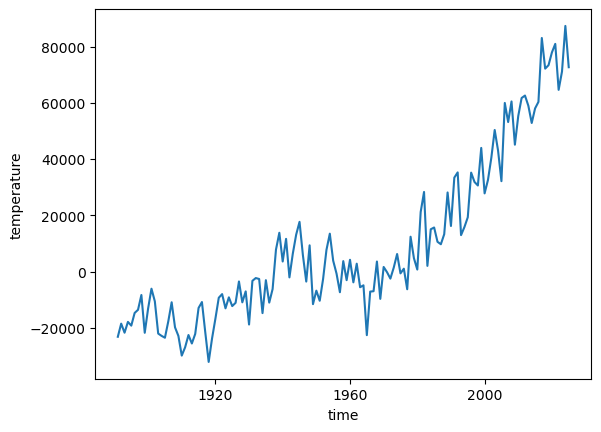

In [61]:
# data_ds.mean(dim=['lat', 'lon']).plot()
data_ds.sum(dim=['lat', 'lon']).plot()

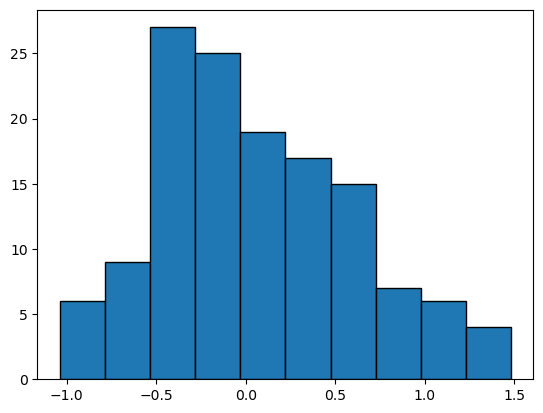

In [62]:
plt.hist(data_ds.sel(lat=-38, lon=145, method='nearest').squeeze().values, edgecolor='k');

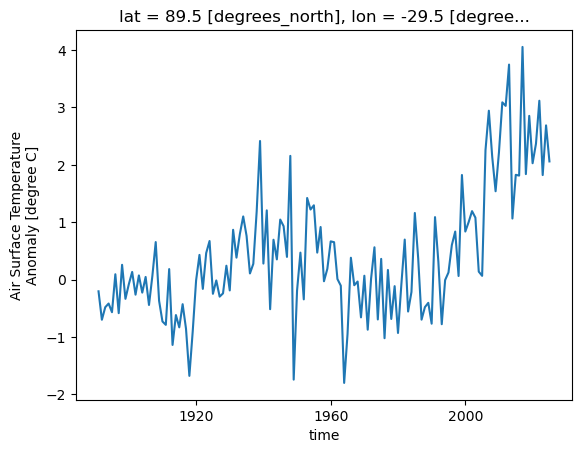

In [63]:
data_ds.sel(lat=89.5, lon=-29.75, method='nearest').plot()

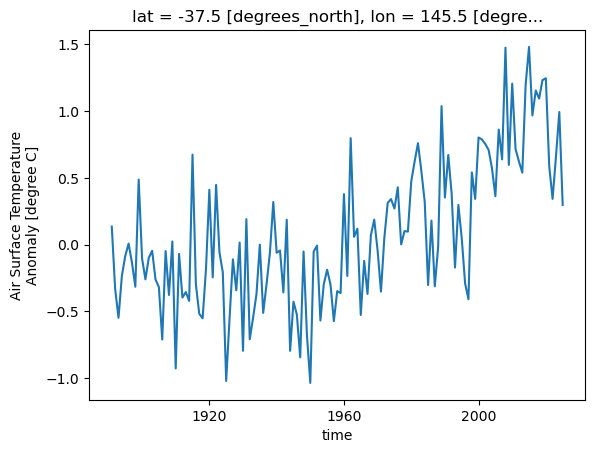

In [64]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

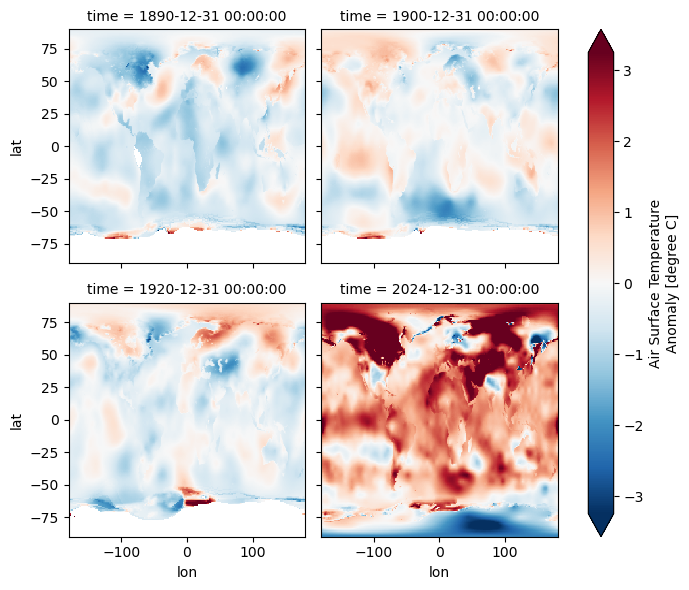

In [65]:
data_ds.isel(time=[0, 10, 30, -1]).plot(col='time', col_wrap=2, robust=True)

In [66]:
# Calculate statistics
min_val = data_ds.min().values.item()
q25_val = data_ds.reduce(np.nanpercentile, q=25).values.item()
q75_val = data_ds.reduce(np.nanpercentile, q=75).values.item()
max_val = data_ds.max().values.item()

# Display nicely
print(f"Statistics:\n"
      f"Min: {min_val:.2f}\n"
      f"25th Percentile: {q25_val:.2f}\n"
      f"75th Percentile: {q75_val:.2f}\n"
      f"Max: {max_val:.2f}")

Statistics:
Min: -7.22
25th Percentile: -0.32
75th Percentile: 0.52
Max: 23.40


In [67]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(135,
 array([cftime.DatetimeGregorian(1890, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(1891, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(1892, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2022, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2023, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2024, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
       dtype=object))

In [68]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(135,
 array([cftime.DatetimeGregorian(1890, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(1891, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(1892, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2022, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2023, 12, 31, 0, 0, 0, 0, has_year_zero=False),
        cftime.DatetimeGregorian(2024, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
       dtype=object))

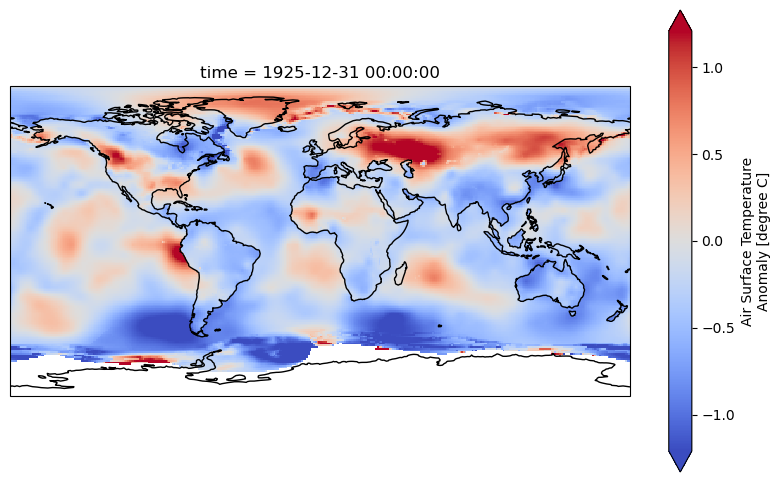

In [69]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=35).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [70]:
base_period_ds = data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
base_period_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 21)> Size: 5MB
dask.array<getitem, shape=(180, 360, 21), dtype=float32, chunksize=(18, 36, 21), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 168B 1890-12-31 00:00:00 ... 1910-12-31 00:00:00
Attributes: (6)

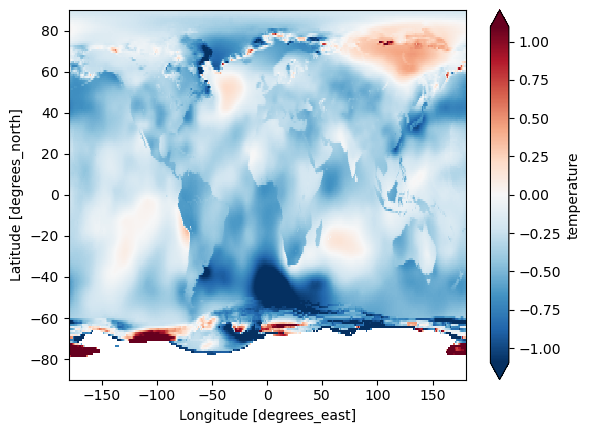

In [71]:
base_period_ds.mean(dim='time').plot(robust=True)

In [72]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
# How many years are needed for 80 percent
percent_80_of_years = 0.8*(base_period.end - base_period.start)
data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)> Size: 518kB
dask.array<where, shape=(180, 360), dtype=int64, chunksize=(18, 36), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

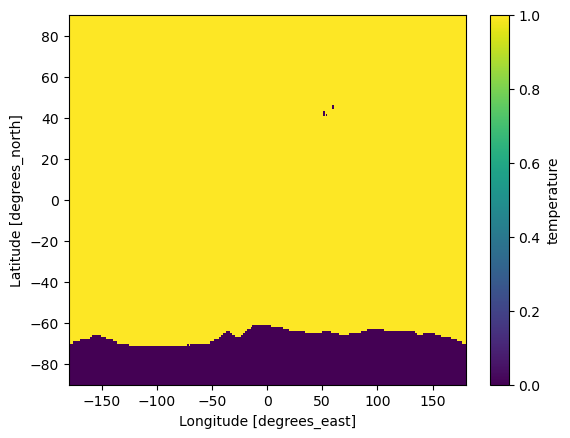

In [73]:
data_availability_mask.plot()

In [74]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [75]:
# Resetting the anomlies to 1850
data_anom_ds = data_ds - base_period_ds.mean(dim='time')
base_period_anom_ds = base_period_ds - base_period_ds.mean(dim='time')

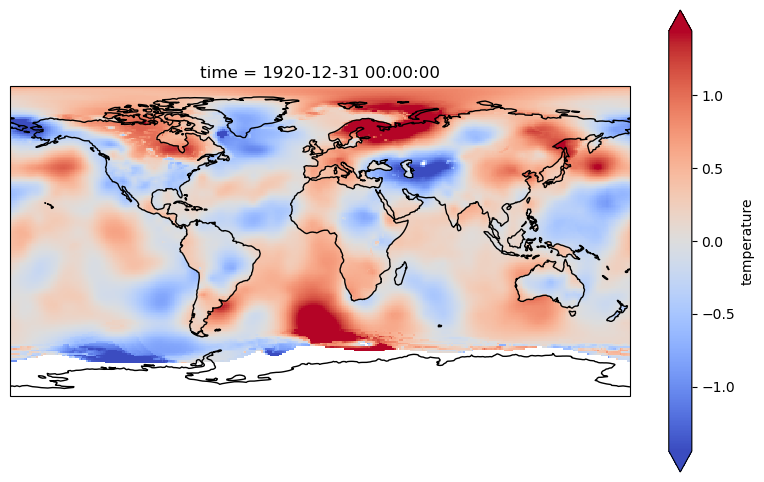

In [76]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_anom_ds.isel(time=30).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

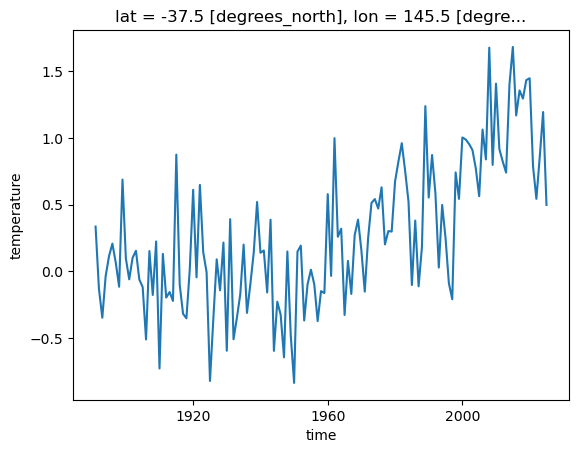

In [77]:
data_anom_ds.sel(lat=-38, lon=145, method='nearest').plot()

In [78]:
data_ds.sel(lat=-38, lon=145, method='nearest').values

array([ 0.13, -0.33, -0.55, -0.24, -0.09,  0.01, -0.14, -0.32,  0.49,
       -0.1 , -0.26, -0.1 , -0.05, -0.26, -0.32, -0.71, -0.05, -0.38,
        0.02, -0.93, -0.07, -0.4 , -0.36, -0.42,  0.67, -0.3 , -0.52,
       -0.55, -0.18,  0.41, -0.25,  0.45, -0.06, -0.21, -1.02, -0.56,
       -0.11, -0.34,  0.01, -0.8 ,  0.19, -0.71, -0.55, -0.37, -0.  ,
       -0.51, -0.3 , -0.06,  0.32, -0.06, -0.04, -0.36,  0.19, -0.8 ,
       -0.43, -0.52, -0.85, -0.05, -0.68, -1.04, -0.05, -0.01, -0.57,
       -0.3 , -0.19, -0.3 , -0.57, -0.35, -0.36,  0.38, -0.24,  0.8 ,
        0.06,  0.12, -0.53, -0.12, -0.37,  0.07,  0.19, -0.04, -0.35,
        0.05,  0.31,  0.34,  0.27,  0.43,  0.  ,  0.1 ,  0.1 ,  0.47,
        0.62,  0.76,  0.55,  0.32, -0.3 ,  0.18, -0.31, -0.01,  1.04,
        0.35,  0.67,  0.38, -0.17,  0.3 ,  0.05, -0.29, -0.41,  0.54,
        0.34,  0.8 ,  0.79,  0.75,  0.71,  0.57,  0.36,  0.86,  0.64,
        1.48,  0.6 ,  1.21,  0.71,  0.62,  0.54,  1.2 ,  1.48,  0.97,
        1.15,  1.09,

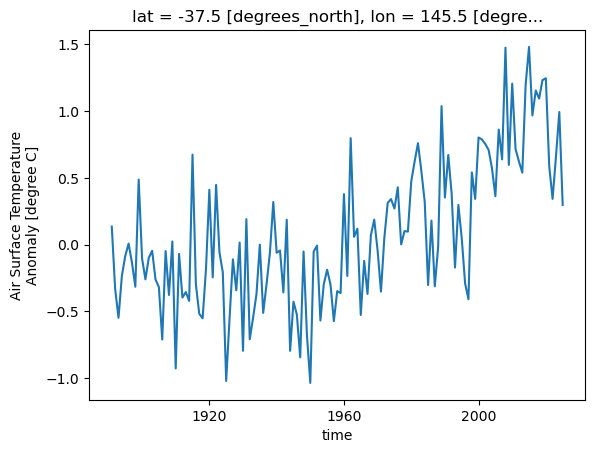

In [79]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

<h1 style='color: yellow'> Metric Calculation </h1>

<h2 style='color: cyan'>Dataset set-up </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

In [80]:
window = 30

In [81]:
CHUNKS_FOR_PVALUE_TESTS = chunks

In [82]:
data_ds_window = (data_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (data_ds.sel(time=slice(str(base_period.start), str(base_period.end)))
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [83]:
wait(data_ds_window);
wait(base_period_window_ds);

In [84]:
data_ds_window

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 135, window_dim: 30)> Size: 1GB
dask.array<rechunk-merge, shape=(180, 360, 135, 30), dtype=float32, chunksize=(18, 36, 135, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1890-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim
Attributes: (6)

In [85]:
data_ds_window.chunks

((18, 18, 18, 18, 18, 18, 18, 18, 18, 18),
 (36, 36, 36, 36, 36, 36, 36, 36, 36, 36),
 (135,),
 (30,))

In [86]:
base_period_window_ds

<xarray.DataArray 'temperature' (lat: 180, lon: 360, window_dim: 21)> Size: 5MB
dask.array<getitem, shape=(180, 360, 21), dtype=float32, chunksize=(18, 36, 21), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon         (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * window_dim  (window_dim) object 168B 1890-12-31 00:00:00 ... 1910-12-31 0...
Attributes: (6)

In [87]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [88]:
# # P-value methods works better with a large cluster.
# # Small chunks with large computation
client.cluster.scale(200);
sleep(7);

 -         Start Nanny at: 'tcp://127.0.0.1:46565'
 -         Start Nanny at: 'tcp://127.0.0.1:35289'
 -         Start Nanny at: 'tcp://127.0.0.1:45225'
 -         Start Nanny at: 'tcp://127.0.0.1:44415'
 -         Start Nanny at: 'tcp://127.0.0.1:39523'
 -         Start Nanny at: 'tcp://127.0.0.1:46513'
 -         Start Nanny at: 'tcp://127.0.0.1:33301'
 -         Start Nanny at: 'tcp://127.0.0.1:38661'
 -         Start Nanny at: 'tcp://127.0.0.1:42745'
 -         Start Nanny at: 'tcp://127.0.0.1:35263'
 -         Start Nanny at: 'tcp://127.0.0.1:42073'
 -         Start Nanny at: 'tcp://127.0.0.1:46147'
 -         Start Nanny at: 'tcp://127.0.0.1:38003'
 -         Start Nanny at: 'tcp://127.0.0.1:40807'
 -         Start Nanny at: 'tcp://127.0.0.1:45165'
 -         Start Nanny at: 'tcp://127.0.0.1:40133'
 -         Start Nanny at: 'tcp://127.0.0.1:46211'
 -         Start Nanny at: 'tcp://127.0.0.1:39751'
 -         Start Nanny at: 'tcp://127.0.0.1:44143'
 -         Start Nanny at: 'tcp

<h2 style='color: cyan'> Overlap Methods - Optimized</h2>

In [89]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

### Perkins

In [90]:
data_arr = data_ds.values.flatten()
data_arr.shape
# #data_arr = data_arr[data_arr != 0]

(8748000,)

In [91]:
bins = toe_calc.calculate_freedman_diaconis_bins(data_arr, length=len(data_ds.time.values),
                                                logginglevel='DEBUG')

np.unique(np.diff(bins).round(6)).item(), bins

p75=0.49870818108320236, p25=-0.32760071009397507, iqr=0.8263088911771774, length=135
 - 0.32215224733934295


(0.322152,
 array([-7.54, -7.22, -6.9 , -6.58, -6.26, -5.93, -5.61, -5.29, -4.97,
        -4.64, -4.32, -4.  , -3.68, -3.36, -3.03, -2.71, -2.39, -2.07,
        -1.75, -1.42, -1.1 , -0.78, -0.46, -0.13,  0.19,  0.51,  0.83,
         1.15,  1.48,  1.8 ,  2.12,  2.44,  2.76,  3.09,  3.41,  3.73,
         4.05,  4.38,  4.7 ,  5.02,  5.34,  5.66,  5.99,  6.31,  6.63,
         6.95,  7.28,  7.6 ,  7.92,  8.24,  8.56,  8.89,  9.21,  9.53,
         9.85, 10.17, 10.5 , 10.82, 11.14, 11.46, 11.79, 12.11, 12.43,
        12.75, 13.07, 13.4 , 13.72, 14.04, 14.36, 14.68, 15.01, 15.33,
        15.65, 15.97, 16.3 , 16.62, 16.94, 17.26, 17.58, 17.91, 18.23,
        18.55, 18.87, 19.19, 19.52, 19.84, 20.16, 20.48, 20.81, 21.13,
        21.45, 21.77, 22.09, 22.42, 22.74, 23.06, 23.38, 23.7 ]))

In [92]:
np.min(bins), np.max(bins)

(-7.5439978741703975, 23.704770117745852)

In [93]:
data_ds.min().values.item(), data_ds.max().values.item()

(-7.221845626831055, 23.400606155395508)

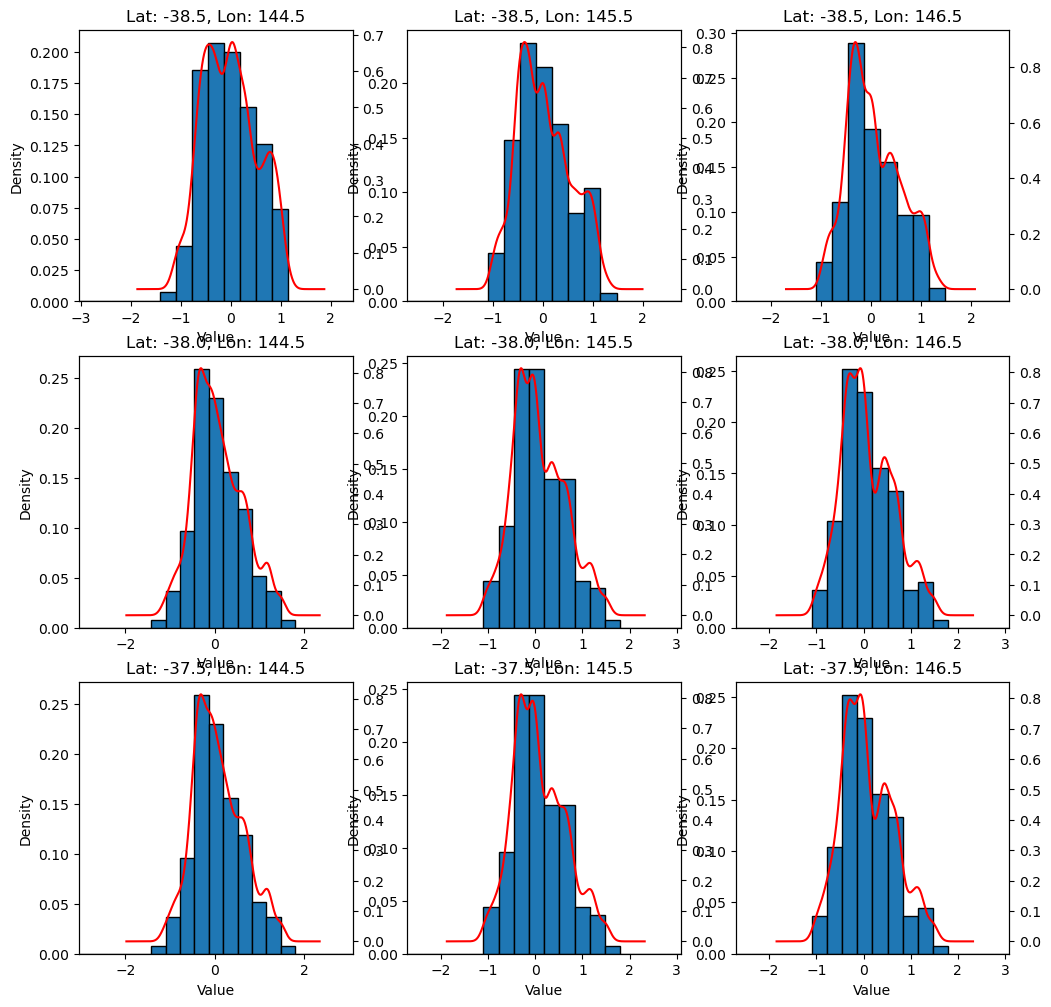

In [94]:
# Example latitudes and longitudes range (adjust as needed)
lats = np.linspace(-38.5, -37.5, 3)  # Replace with your actual latitudes
lons = np.linspace(144.5, 146.5, 3)  # Replace with your actual longitudes

# Create a 3x3 plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through latitudes and longitudes
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        # Extract the data for the current lat, lon
        test_data = data_ds.sel(lat=lat, lon=lon, method='nearest').values
        
        # Compute the KDE
        _, rel_freq = toe_calc.discrete_pdf(test_data, bins=bins)
        x_test, kde_test = toe_calc.create_kde(test_data, **kde_kwargs)

        # Plot on the current subplot
        ax = axs[i, j]
        ax2 = ax.twinx()
        ax.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
        ax2.plot(x_test, kde_test, color='r')
        ax.set_title(f'Lat: {lat}, Lon: {lon}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        valid_bins = bins[:-1][rel_freq > 0]
        x_min, x_max = valid_bins.min()-5*np.diff(bins)[0], valid_bins.max()+5*np.diff(bins)[0]
        ax.set_xlim(x_min, x_max)

In [95]:
%%time
# Pre-calculate the relative frequency of the base period

base_period_rel_freq_ds = xr.apply_ufunc(
    toe_calc.get_rel_freq,
    base_period_ds,
    input_core_dims=[['time']],
    output_core_dims=[['bins']],
    kwargs={'bins': bins},
    vectorize=True,
    dask='parallelized',
    output_sizes={'bins': len(bins) - 1}, 
    output_dtypes=float
).persist()
wait(base_period_rel_freq_ds)

/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py:271: RuntimeWarning: invalid value encountered in divide
  rel_freq = counts / len(arr)
/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py:271: RuntimeWarning: invalid value encountered in divide
  rel_freq = counts / len(arr)
/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py:271: RuntimeWarning: invalid value encountered in divide
  rel_freq = counts / len(arr)
/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py:271: RuntimeWarning: invalid value encountered in divide
  rel_freq = counts / len(arr)
/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py:271: RuntimeWarning: invalid value encountered in divide
  rel_freq = counts / len(arr)
/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py:271: RuntimeWarning: invalid value encountered in divide
  rel_freq = counts / len(arr)
/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc.py:271

CPU times: user 4.35 s, sys: 3.14 s, total: 7.49 s
Wall time: 7.78 s


DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-4576f26c512f4f554f756652666b7305', 4, 1, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-4576f26c512f4f554f756652666b7305', 8, 5, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-4576f26c512f4f554f756652666b7305', 7, 9, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-4576f26c512f4f554f756652666b7305', 3, 5, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-4576f26c512f4f554f756652666b7305', 7, 4, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-4576f26c512f4f554f756652666b7305', 2, 5, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-4576f26c512f4f554f756652666b7305', 9, 2, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-4576f26c512f4f554f756652666b7305', 5, 7, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-4576f26c512f4f554f756652666b7305', 0, 9, 0)>, <Future: finished, type: numpy.ndarray, key: 

In [96]:
%%time
perkins_ds = xr.apply_ufunc(
    toe_calc.perkins_skill_score_base_bins,
    data_ds_window,
    base_period_rel_freq_ds,
    kwargs={'bins': bins},
    input_core_dims=[['window_dim'], ['bins']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
    ).compute()

CPU times: user 4.49 s, sys: 3.2 s, total: 7.69 s
Wall time: 8.12 s


In [97]:
perkins_ds = perkins_ds.sortby('lat')

In [98]:
perkins_ds.attrs = {
    'window': window,
    **perkins_ds.attrs,
    'bins': 
    {
        'start':bins.round(4)[0],
        'stop':bins.round(4)[-1],
        'step': np.unique(np.diff(bins)).round(4)[0]}
}

In [99]:
location = dict(lat=69, lon=-165, method='nearest')

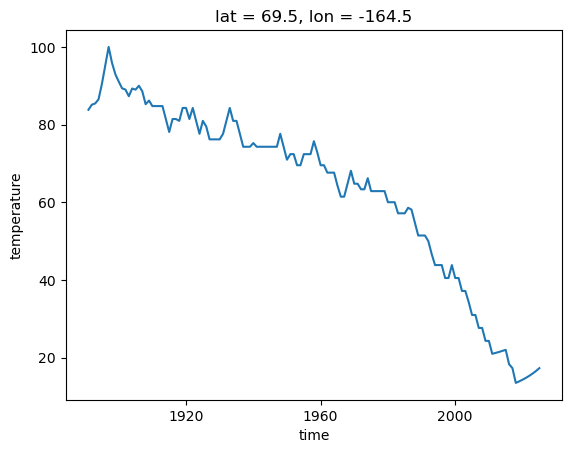

In [100]:
perkins_ds.sel(**location).plot()

In [101]:
base_arr = base_period_ds.sel(**location).values
rel_freq_base = toe_calc.rel_freq(base_arr, bins)
future_arr = data_ds.sel(**location).where(
    data_ds.time.dt.year.isin(np.arange(base_period.start, base_period.start+window+1)), drop=True).values
rel_freq_future = toe_calc.rel_freq(future_arr, bins=bins)

In [102]:
toe_calc.discrete_distribution_overlap(rel_freq_base, rel_freq_future),\
toe_calc.perkins_skill_score(future_arr, base_arr, bins=bins),\
perkins_ds.sel(**location).isel(time=int(window/2)).values.item()

(90.78341013824884, 90.78341013824884, 89.99999999999999)

<Axes: >

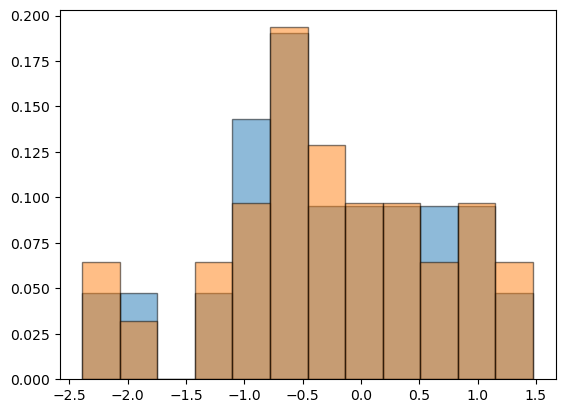

In [103]:
fig, ax = plt.subplots(1, 1)
diagnostic_tools.plot_bar(bins, rel_freq_base, ax=ax)
diagnostic_tools.plot_bar(bins, rel_freq_future, ax=ax)

In [104]:
toe_calc.perkins_skill_score_base_bins(
    data_ds_window.sel(lat=-39, lon=145,method='nearest').isel(time=slice(None, 30)).values,
    base_period_rel_freq_ds.sel(lat=-39, lon=145,method='nearest').values,
    bins=bins
)

92.2893772893773

<BarContainer object of 97 artists>

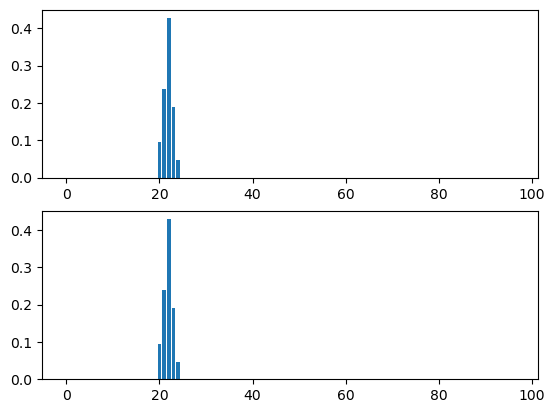

In [105]:
fig, (ax1, ax2) = plt.subplots(2, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')
rel_freq_test = toe_calc.get_rel_freq(base_period_ds.sel(**test_loc).squeeze().values, bins=bins)

ax1.bar(base_period_rel_freq_ds.bins.values, rel_freq_test)
ax2.bar(base_period_rel_freq_ds.bins.values, base_period_rel_freq_ds.sel(**test_loc).values)

 - locator: <matplotlib.ticker.AutoLocator object at 0x14632da0a050>


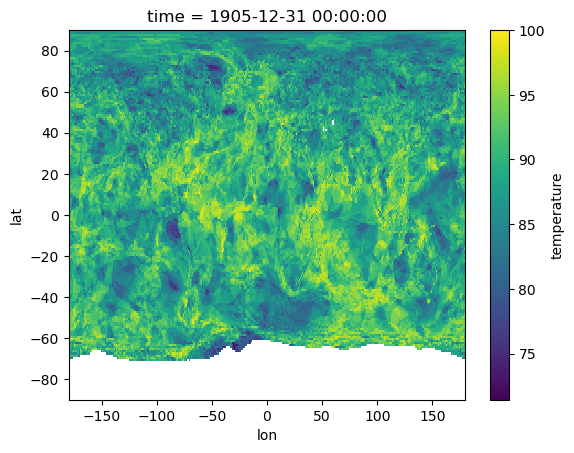

In [106]:
perkins_ds.isel(time=int(window/2)).plot();

 - locator: <matplotlib.ticker.FixedLocator object at 0x14632d9e79d0>


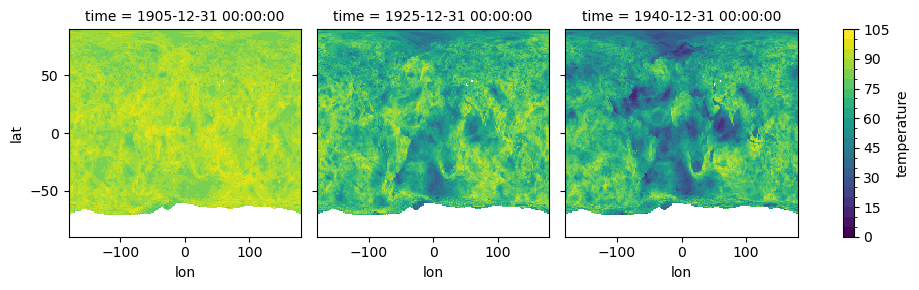

In [107]:
perkins_ds.isel(time=[int(window/2), 35, 50]).plot(col='time', levels=np.arange(0, 110, 5))

### KDE Metrics

In [108]:
# The x-values for the KDE are based upon the max and min
data_max = data_ds.max().persist().values.item()
data_min = data_ds.min().persist().values.item()
num_points = 1000
x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)

data_min, data_max, x.shape

(-7.221845626831055, 23.400606155395508, (1000,))

In [109]:
%%time
# Pre-calculate the base period KDE

base_period_kde = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    base_period_ds,
    input_core_dims=[['time'], ],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=float
).persist()
wait(base_period_kde);

CPU times: user 1.22 s, sys: 784 ms, total: 2.01 s
Wall time: 2 s


In [110]:
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
# # latlon_dict = dict(lat=-38, lon=145, method='nearest')
latlon_dict = dict(lat=0.5, lon=-29.75, method='nearest')
toe_calc.hellinger_distance_optimized(
    arr_future=data_ds_window.sel(**latlon_dict).isel(time=slice(30, 60)).values,
    kde_base = base_period_kde.sel(**latlon_dict).values,
    x=x
)

50.59084459944272

In [111]:
%%time
hellinger_ds = xr.apply_ufunc(
    toe_calc.hellinger_distance_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()

CPU times: user 22 s, sys: 21.2 s, total: 43.2 s
Wall time: 45 s


In [112]:
%%time
frac_geom_ds = xr.apply_ufunc(
    toe_calc.fractional_geometric_area_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()
# wait(frac_geom_ds2)

CPU times: user 21.7 s, sys: 21.2 s, total: 43 s
Wall time: 44.5 s


In [113]:
x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}
hellinger_ds.attrs =  {'window': window, **hellinger_ds.attrs, **kde_kwargs, **x_attrs}

In [114]:
hellinger_ds.attrs

{'window': 30,
 'bw_method': 0.2,
 'bmin': -7.221845626831055,
 'bmax': 23.400606155395508,
 'num_points': 1000}

 - locator: <matplotlib.ticker.FixedLocator object at 0x14632c4ebb20>


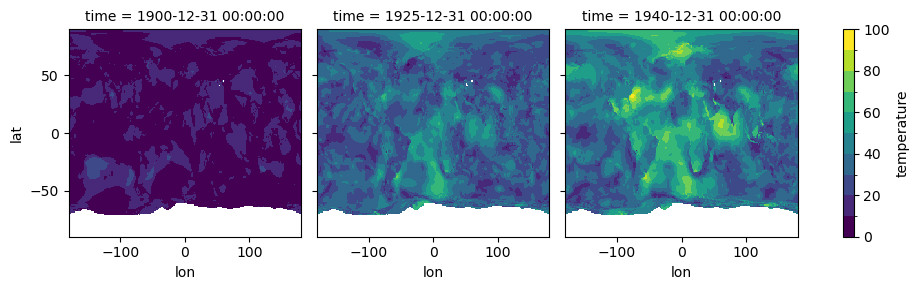

In [115]:
hellinger_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

 - locator: <matplotlib.ticker.FixedLocator object at 0x14632c2bbb50>


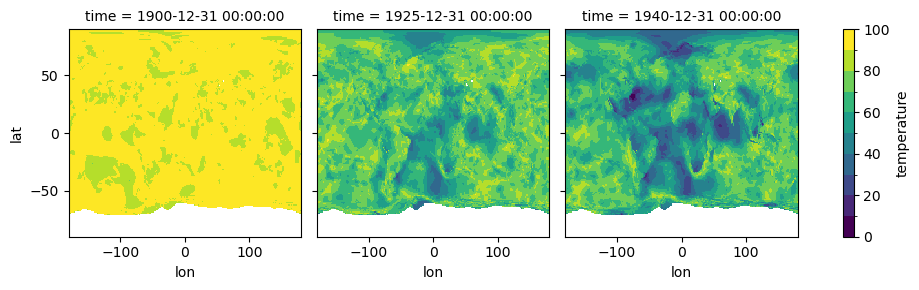

In [116]:
frac_geom_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

 - locator: <matplotlib.ticker.AutoLocator object at 0x14632c163730>


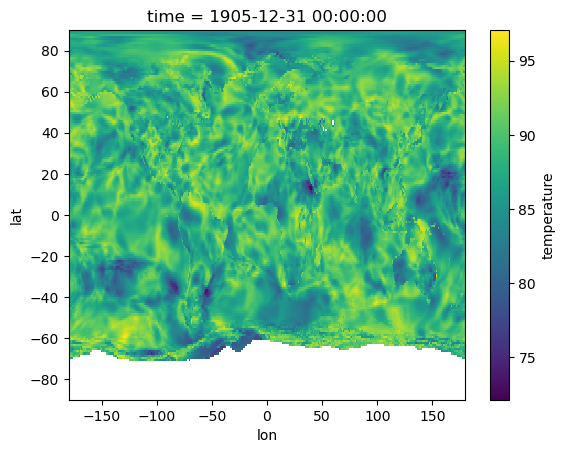

In [117]:
frac_geom_ds.isel(time=window//2).plot();

 - locator: <matplotlib.ticker.AutoLocator object at 0x14632d8a14e0>


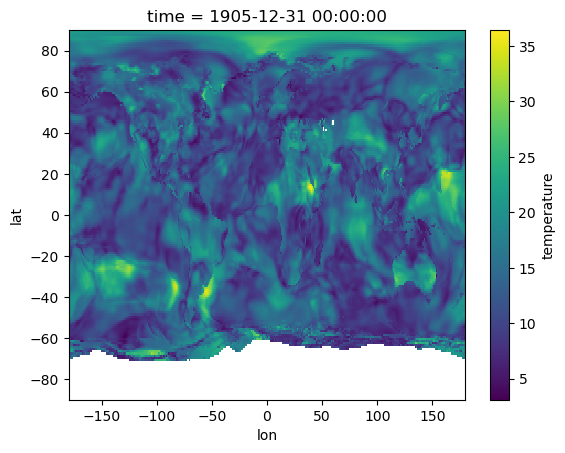

In [118]:
hellinger_ds.isel(time=window//2).plot();

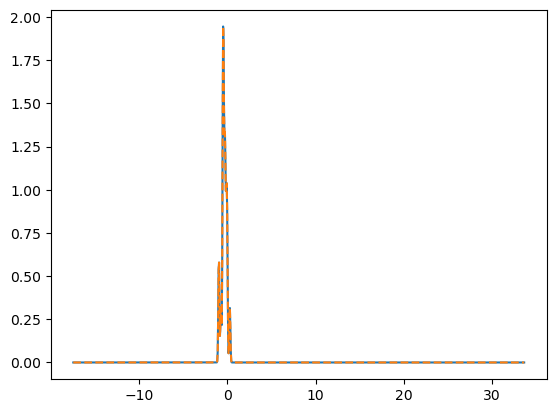

In [119]:
fig, ax1 = plt.subplots(1, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')

test_kde = toe_calc.create_kde_x_exists(base_period_ds.sel(**test_loc).values, x, **kde_kwargs)

ax1.plot(x, base_period_kde.sel(**test_loc).values)
ax1.plot(x, test_kde, linestyle='--')

### Old - Ufunc

In [120]:
# %%time
# perkins_ds = xr.apply_ufunc(
#     toe_calc.perkins_skill_score,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs={'bins': bins},
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute().sortby('lat')

In [121]:
# %%time
# frac_geom_ds = xr.apply_ufunc(
#     toe_calc.fractional_geometric_area,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

In [122]:
# %%time
# hellinger_ds = xr.apply_ufunc(
#     toe_calc.hellinger_distance,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

<h2 style='color: cyan'> P-value Methods </h2>

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [123]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [124]:
%%time
# Expected: 9 minutes 30 seconds
ttest_ds = xr.apply_ufunc(
        toe_calc.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

2025-02-22 13:58:01,082 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('vectorize_return_statistical_pvalue-vectorize_return_statistical_pvalue_0-transpose-d8fcb60b47d5827fa6d6a369dfd6a24--d9f', 1, 3, 0))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2025-02-22 13:58:01,082 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('vectorize_return_statistical_pvalue-vectorize_return_statistical_pvalue_0-transpose-d8fcb60b47d5827fa6d6a369dfd6a24--d9f', 5, 0, 0))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2025-02-22 13:58:01,082 - distributed.worker.state_machine - WARNING - Async instruction for <

KeyboardInterrupt: 

In [ ]:
ttest_ds

In [ ]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe_calc.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

In [ ]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_availability_mask)

In [ ]:
# %%time
# anderson_ds = xr.apply_ufunc(
#     toe_calc.return_anderson_pvalue,
#     data_ds_window,
#     base_period_window_ds,
#     output_dtypes=float, 
#     **rolling_window_kwargs
#     ).compute()

### Verification of p-value test
- Comparison with 1d rolling func
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [ ]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [ ]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length=base_period.length+1)

In [ ]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).values)

In [ ]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

<h2 style='color: cyan'> Signal-to-Noise </h2>

<b> Hawkins S/N Ratio</b>

In [ ]:
# Calculate the wegithed mean
data_ds_smean = climate_utils.weighted_lat_lon_mean(data_anom_ds).compute()

In [ ]:
data_ds_smean.plot()

In [ ]:
# Get lowess filtered version
ds_smean_lowess = my_stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [ ]:
%%time
return_hawkins_signal_and_noise_partial = partial(toe_calc.return_hawkins_signal_and_noise, 
                                                  gt=ds_smean_lowess.values)

ds_signal_hawkins, ds_noise_series_hawkins = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    data_anom_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True,
    output_dtypes=[float, float],
)

ds_signal_hawkins = ds_signal_hawkins.compute()
ds_noise_series_hawkins = ds_noise_series_hawkins.compute()

In [ ]:
# Noise 
ds_noise_hawkins_full = ds_noise_series_hawkins.std(dim='time').compute()

ds_noise_hawkins_base_period = ds_noise_series_hawkins.where(
    ds_noise_series_hawkins.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio 
ds_sn_hawkins_full = ds_signal_hawkins/ds_noise_hawkins_full
ds_sn_hawkins_base_period = ds_signal_hawkins/ds_noise_hawkins_base_period

<b> Lowess S/N </b>

In [ ]:
ds_signal_lowess = xr.apply_ufunc(
    my_stats.apply_lowess, 
    data_anom_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    kwargs = dict(window=41),
    dask='parallelized',
    output_dtypes=[float]
).compute()

In [ ]:
# Noise series is detrended data
ds_noise_series_lowess = (data_anom_ds - ds_signal_lowess).compute()
# Noise is std of detrended data
ds_noise_lowess_full = ds_noise_series_lowess.std(dim='time')

ds_noise_lowess_base_period = ds_noise_series_lowess.where(
    ds_noise_series_lowess.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio
ds_sn_lowess_full = ds_signal_lowess/ds_noise_lowess_full
ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period

In [ ]:
ds_signal_mean = data_anom_ds.rolling(time=window, center=True).mean().persist()

# data_detrend_mean = (data_anom_ds - ds_signal_mean).persist()
# Detrended usign lowess or else 2 x 15 year periods on either end is lost
ds_std_roll = ds_noise_series_lowess.rolling(time=window, center=True).std().persist()

ds_sn_mean = ds_signal_mean/ds_noise_series_lowess.std(dim='time').persist()

In [ ]:
# base_period_std = data_detrend_mean.sel(time=slice(str(base_period.start), str(base_period.end))).std(dim='time').persist()

In [ ]:
ds_rolling_noise = (np.sqrt(1/2*(ds_noise_lowess_base_period**2+ds_std_roll**2))).persist()

In [ ]:
ds_sn_mean_roll = (ds_signal_mean/ds_rolling_noise).persist()

### Plot Verificaiton

In [ ]:
lat_lon_sp = dict(lat=-38, lon=145, method='nearest')

In [ ]:
ds_std_roll.sel(**lat_lon_sp).plot()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax1 = axes[0]
data_anom_ds.sel(**lat_lon_sp).plot(label='data', ax=ax1, color='grey', linestyle='--', alpha=0.5)
ds_signal_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax1)
ds_signal_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax1)
ds_signal_mean.sel(**lat_lon_sp).plot(label='mean', ax=ax1)

ax1.set_title('Signal')
ax1.legend()

#####
ax2= axes[1]
ds_noise_series_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax2)
ds_noise_series_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax2)
# data_detrend_mean.sel(**lat_lon_sp).plot(label='mean', ax=ax2)
ds_rolling_noise.sel(**lat_lon_sp).plot(label='mean rolling', ax=ax2)
ax2.set_title('Noise Series')

ax2.legend()


####
ax3= axes[2]
ds_sn_lowess_full.sel(**lat_lon_sp).plot(label='lowess full', ax=ax3)
ds_sn_lowess_base_period.sel(**lat_lon_sp).plot(label='lowess base', ax=ax3)
ds_sn_mean.sel(**lat_lon_sp).plot(label='mean', ax=ax3)
ds_sn_mean_roll.sel(**lat_lon_sp).plot(label='mean roll', ax=ax3)



ds_sn_hawkins_full.sel(**lat_lon_sp).plot(label='hawkins full', ax=ax3)
ds_sn_hawkins_base_period.sel(**lat_lon_sp).plot(label='hawkins base', ax=ax3)
ax3.set_title('S/N Ratio')
ax3.axhline(1)
ax3.legend()

In [ ]:
ds_signal_lowess.isel(time=[0, 30, 50]).plot(col='time', robust=True)

In [ ]:
# Rolling noise variant
# ds_data_noise_lowess_rolling = ds_data_noise_series_lowess.rolling(time=window, min_periods=2).std(dim='time').compute()
# First time step is nan, so remove
# ds_data_noise_lowess_rolling = ds_data_noise_lowess_rolling.isel(time=slice(1, None))
# This is odd. But I am making the fire 19 years (wnindow lenght) have the same noise as the first time the 
# variability can be calculated.
# ds_data_noise_lowess_rolling = xr.concat([
#     ds_data_noise_lowess_rolling.isel(time=slice(0, window-2)).fillna(ds_data_noise_lowess_rolling.isel(time=window-1)),
#     ds_data_noise_lowess_rolling.isel(time=slice(window-1, None))], dim='time')
# ds_data_noise_lowess_rolling = misc.adjust_time_from_rolling(ds_data_noise_lowess_rolling, window)

In [ ]:
# ds_data_noise_lowess_rolling.sel(lat=-40, lon=144, method='nearest')

In [ ]:
# ds_data_sn_lowess_rolling = ds_data_signal_lowess/ds_data_noise_lowess_rolling
# # First time step is nan for noise, so remove
# ds_data_sn_lowess_rolling = ds_data_sn_lowess_rolling.isel(time=slice(1, None))

In [ ]:
# ds_data_noise_lowess_rolling.sel(lat=-38, lon=145, method='nearest').plot()

In [ ]:
# ds_data_sn_lowess

In [ ]:
# client.cluster.scale(6)
# sleep(7)

<h1 style='color: yellow'>  Data Mering and Save </h1>

In [ ]:
# ds_signal_mean
# ds_sn_mean
# ds_rolling_noise
# ds_sn_mean_roll

In [ ]:
ds_signal_lowess.name = 'signal_lowess'
ds_noise_series_lowess.name = 'noise_lowess'
ds_signal_hawkins.name = 'signal_hawkins'
ds_noise_series_hawkins.name = 'noise_hawkins'

ds_signal_mean.name = 'signal_mean'
ds_rolling_noise.name = 'noise_rolling'

In [ ]:
ds_sn_hawkins_full.name = 'sn_hawkins_full'
ds_sn_hawkins_base_period.name = 'sn_hawkins_base'
ds_sn_lowess_full.name = 'sn_lowess_full'
ds_sn_lowess_base_period.name = 'sn_lowess_base'
ds_sn_mean.name = 'sn_mean'
ds_sn_mean_roll.name = 'sn_mean_roll'

ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hellinger_ds.name = 'hd'

In [ ]:
# Set long name attributes for each variable
ds_sn_hawkins_full.attrs['long_name'] = 'S/N Ratio (Hawkins, full)'
ds_sn_hawkins_base_period.attrs['long_name'] = 'S/N Ratio (Hawkins, base)'

ds_sn_lowess_full.attrs['long_name'] = 'S/N Ratio (LOWESS, full)'
ds_sn_lowess_base_period.attrs['long_name'] = 'S/N Ratio (LOWESS, base)'

ds_sn_mean.attrs['long_name'] = 'S/N Ratio (Mean, base)'
ds_sn_mean_roll.attrs['long_name'] = 'S/N Ratio (Mean, base+rolling)'


ttest_ds.attrs['long_name'] = 'T-Test'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'
hellinger_ds.attrs['long_name'] = 'Hellinger Distance'

In [ ]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, perkins_ds, frac_geom_ds, hellinger_ds,
                           ds_sn_hawkins_full,ds_sn_hawkins_base_period,
                          ds_sn_lowess_full, ds_sn_lowess_base_period,
                          ds_sn_mean, ds_sn_mean_roll])

toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

In [ ]:
dataset_name, variable, base_period

In [ ]:
VAR_SAVE_DIR

In [ ]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'data.zarr')
print(DATA_SAVE_NAME)
data_anom_ds.to_zarr(DATA_SAVE_NAME, mode='w')

In [ ]:
# THe signal is actually needed for lots of plots
singal_ds = xr.merge([
    ds_signal_lowess,ds_noise_series_lowess ,ds_signal_hawkins , ds_noise_series_hawkins,
    ds_signal_mean, ds_rolling_noise]) 
singal_ds

In [ ]:
SIGNAL_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'signal.zarr')
print(SIGNAL_SAVE_NAME)
singal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

In [ ]:
TOE_METRICS_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'toe_metrics.zarr')
print(TOE_METRICS_SAVE_NAME)
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')

In [ ]:
data_availability_mask

In [ ]:
DATA_AVAILABILITY_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'data_availability_mask.zarr')
print(DATA_AVAILABILITY_SAVE_NAME)
data_availability_mask.to_zarr(DATA_AVAILABILITY_SAVE_NAME, mode='w')

In [ ]:
t_end = time()
time_taken = (t_end - t_start)/60
print(f'{time_taken=}minutes')